<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/patient_image.png" width="30%" align="right"/>

# Building a Binary Classification Machine Learning Model To Predict Hospital Readmission in Patients with Diabetes

In this tutorial, we'll be looking at hospital admission data in patients with diabetes. This dataset was collected from 130 hospitals in the United States from 1999 to 2008. More details can be found on the UCI Machine Learning Repository [website](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

## Step 1: Importing Depedencies

Before getting started, we'll need to import several packages. These include:

- [pandas](https://pandas.pydata.org/pandas-docs/stable/) - a package for performing data analysis and manipulation
- [numpy](https://docs.scipy.org/doc/numpy/) - a package for scientific computing 
- [matplotlib](https://matplotlib.org/) - the standard Python plotting package
- [seaborn](https://seaborn.pydata.org/) - a dataframe-centric visualization package that is built off of **matplotlib**

In [67]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load the Data

We will be loading in the data as a pandas DataFrame.

The data is stored in a csv file. We'll import this data using a pandas method called `read_csv`.

In [68]:
data = pd.read_csv("../data/patient_data.csv")

To get a glimpse of our data, we can use either the `head()`, which shows the first 5 rows of the dataframe.

In [3]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,1,1,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,7,3,NaN,...,No,No,Up,No,No,No,No,No,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,7,2,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,7,2,NaN,...,No,No,Up,No,No,No,No,No,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,7,1,NaN,...,No,No,Steady,No,No,No,No,No,Yes,NO


### How many rows and columns are in our dataset?

In [4]:
data.shape

(101766, 44)

Our dataset has 101,766 rows and 45 columns. Each row represents a unique hospital admission. Columns represent patient demographics, medical details, and admission-specific information such as length of stay (`time_in_hospital`). We can see a list of all columns by applying `.columns` to our dataframe.

In [5]:
print(f"Columns: {data.columns.tolist()}")

Columns: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetesMed', 'readmitted']


Looking at the columns, we can see that a large proportion are medication names. Let's store these column names as a separate list, which we'll get back to in a bit.

In [6]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

print(f"There are {len(medications)} medications represented as columns in the dataset.")

There are 23 medications represented as columns in the dataset.


### How many hospital admissions and unique patients are in the dataset? 

In [7]:
n_admissions = data['encounter_id'].nunique()
n_patients = data['patient_nbr'].nunique()

print(f"Number of hospital admissions: {n_admissions:,}")
print(f"Number of unique patients: {n_patients:,}")

Number of hospital admissions: 101,766
Number of unique patients: 71,518


### How many patients have had more than one hospital admission?

In [8]:
admissions_per_patient = data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

In [9]:
print(f"Proportion of patients that have multiple admissions: {multiple_admissions['patient_nbr'].nunique()/n_patients:.2%}")
print(f"Maximum number of admissions for a given patient: {multiple_admissions['count'].max()}")

Proportion of patients that have multiple admissions: 23.45%
Maximum number of admissions for a given patient: 40


Almost one-quarter of the patients (23.45%) have had more than 1 hosptial admission. The maximum number of hospital admissions for a given patient is 40. 

## Step 3: Data Cleaning

Data cleaning is a crucial step in the machine learning pipeline, and typically requires the most time and effort in any data science project.

### Decoding `admission_type_id`

The `admission_type_id` column describes the type of admission and is represented by integers. The `id` column links to descriptors found in a separate file. 

We'll update this column so that it represents the descriptor name instead of simply the id number.

Our mapper files are located in `data/id_mappers/`.

In [10]:
import glob

glob.glob('../data/id_mappers/*.csv')

['../data/id_mappers/admission_source_id.csv',
 '../data/id_mappers/admission_type_id.csv']

In [11]:
admission_type = pd.read_csv("../data/id_mappers/admission_type_id.csv")
admission_type

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


We can see that the admission type mapper file has 3 values which represent missing data:

1. NaN
2. 'Not Mapped'
3. 'Not Available'

Let's collapse these into one category that represents a missing value. We can use `pandas` [replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.replace.html) method to do this. 

In [12]:
missing_values = ['nan', 'Not Available', 'Not Mapped']
admission_type['description'] = admission_type['description'].replace(missing_values, np.nan)

In [13]:
admission_type_mapper = admission_type.to_dict()['description']
admission_type_mapper

{0: 'Emergency',
 1: 'Urgent',
 2: 'Elective',
 3: 'Newborn',
 4: nan,
 5: nan,
 6: 'Trauma Center',
 7: nan}

Now that we have a "clean" mapper, we can apply it to our dataset. We can [map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) `admission_type_id` values in our original dataframe to the descriptors in our `admission_type_mapper` dictionary.

In [14]:
data['admission_type'] = data['admission_type_id'].map(admission_type_mapper)
data['admission_type'].value_counts()

Urgent           53990
Newborn          18869
Elective         18480
Trauma Center     5291
Name: admission_type, dtype: int64

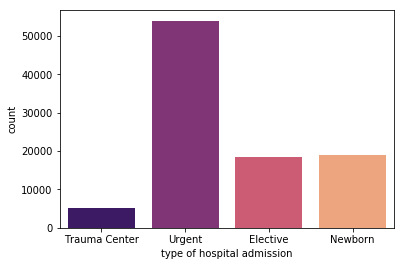

In [15]:
sns.countplot(x='admission_type', data=data, palette='magma')
plt.xlabel('type of hospital admission')
plt.show()

### Converting Medication Features From Categorical to Boolean

Remember that list of medications we created when we loaded in the data in Step 1? We're going to take these medication columns in our dataset and convert these features to boolean variables. 

In [16]:
data[medications[0]].value_counts()

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64

Medication columns are currently categorical datatypes that have several possible categories including:

- "No" (not taking the medication)
- "Up" (increased medication dose)
- "Down" (decrease medication dose)
- "Steady" (no changes in dose)

To keep things simple, we'll update the column to "0" (not taking the medication) to "1" (taking the medication). We're losing out on information regarding their dose change, but it's a compromise we're willing to make in order to simplify our dataset.

We can use [numpy.where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) to convert all instances of "No" to `0` and everything else (i.e., "Up", "Down", "Steady") to `1`. Let's loop through all medications and convert each column to boolean.

In [17]:
for m in medications:
    data[f'{m}_bool'] = np.where(data[m]=='No', 0, 1)

Our medication data are now represented as boolean features. Let's take a look at the prevelance of these medications. We'll calcualte the proportion of patients taking each type of medication. Because some patients have had multiple hospital admissions in this dataset, we'll need to do some wrangling to determine whether a patient was on a given medication during any of their admissions. The wrangling process consists of the following steps:

- applying `groupby` to `patient_nbr` and calculate the sum of admissions in which the patient was administered a medication
- convert the column to boolean such that patients that have "0" are False and "1" is True
- calculate the sum of patients on that specific medication
- calculate the proportion of patients who were administered that medication

In [18]:
prevelance = []

for m in medications:
    patient_meds = data.groupby('patient_nbr')[f'{m}_bool'].sum().reset_index()
    patient_meds[f'{m}_bool'] = patient_meds[f'{m}_bool'].astype(bool)
    n_patients_on_med = patient_meds[f'{m}_bool'].sum()
    proportion = n_patients_on_med/n_patients
    prevelance.append(proportion)

Now that we have a list of medication prevelance, we can create a dataframe and sort by prevelance to determine which medications are most prevelant in our dataset. 

In [19]:
medication_counts = pd.DataFrame({'medication': medications, 'prevelance':prevelance})
medication_counts = medication_counts.sort_values(by='prevelance', ascending=False)
medication_counts.head()

,medication,prevelance
17,insulin,0.553385
0,metformin,0.230390
6,glipizide,0.139797
7,glyburide,0.119662
9,pioglitazone,0.083042


Let's also visualize the top 10 most prevelance medications. We'll use `seaborn`'s [barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) method.

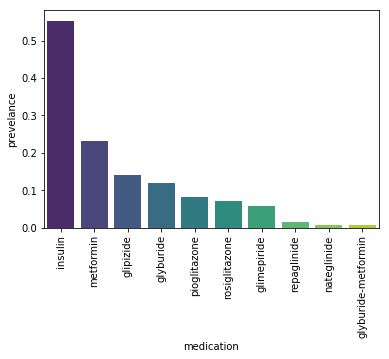

In [20]:
sns.barplot(x='medication', y='prevelance', data=medication_counts.head(10), palette='viridis')
plt.xticks(rotation=90)
plt.show()

In [21]:
from utils import get_mesh_from_drug_name

top_ten_meds = medication_counts.head(10)['medication'].tolist()

med_mesh_descriptors = dict()
for m in top_ten_meds:
    med_mesh_descriptors[m] = get_mesh_from_drug_name(m)

In [22]:
med_mesh_descriptors

{'insulin': [],
 'metformin': ['Hypoglycemic Agents'],
 'glipizide': ['Hypoglycemic Agents'],
 'glyburide': ['Hypoglycemic Agents'],
 'pioglitazone': ['Hypoglycemic Agents'],
 'rosiglitazone': ['Hypoglycemic Agents'],
 'glimepiride': ['Hypoglycemic Agents',
  'Anti-Arrhythmia Agents',
  'Immunosuppressive Agents'],
 'repaglinide': ['Hypoglycemic Agents'],
 'nateglinide': ['Hypoglycemic Agents'],
 'glyburide-metformin': ['Hypoglycemic Agents']}

MeSH terms are a type of "tag" that describes a medical term. We used RxNav's API to further investigate which MeSH terms are assocaited with our list of medications. The results show that all medications have the MeSH term [hypoglycemic agent](https://en.wikipedia.org/wiki/Anti-diabetic_medication), which means it's an anti-diabetic medication. Interestingly, the medication `glimepiride` also has two other associated MeSH terms 'Anti-Arrhythmia Agents' and 'Immunosuppressive Agents' in addition to it being a hypoglycemic agent.


If you want to learn more about each medication in our dataset, check out the [RxNav dashboard](https://mor.nlm.nih.gov/RxNav/) which gives an overview of medication properties and interactions.

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/rxnav_dashboard.png" width="70%"/>

### Creating a Target Variable

The goal of our model will be to predict whether a patient will get readmitted to the hospital. Looking at the `readmitted` column, we see that there are 3 possible values: 

1. `NO` (not readmitted)
2. `>30` (readmitted more than 30 days after being discharged)
3. `<30` (readmitted within 30 days of being discharged)

In [23]:
data['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

To keep things simple, we'll view this as a binary classification problem: did the patient get readmitted? We're going to use `numpy.where` to convert all instances of "NO" to 0 (means patient did not get readmitted) and everyhting else to 1 (patient did get readmitted).

In [24]:
data['readmitted_bool'] = np.where(data['readmitted']=='NO', 0, 1)
data['readmitted_bool'].value_counts()

0    54864
1    46902
Name: readmitted_bool, dtype: int64

## Step 4: Data Exploration and Visualization

### Assessing Missing Values

To get a better sense of the missing values in our data, let's visualize it using [missingno](https://github.com/ResidentMario/missingno)'s "nullity" matrix.

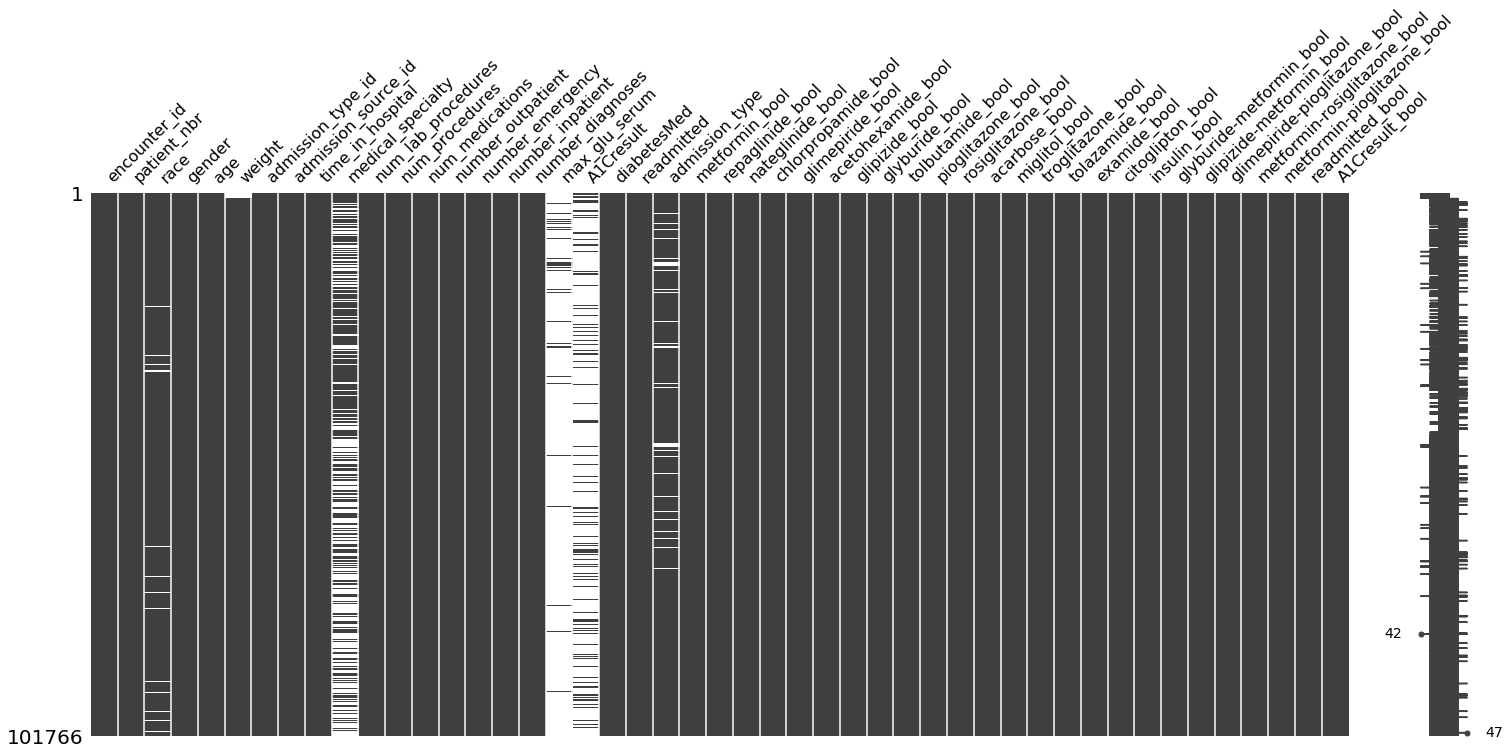

In [45]:
import missingno as msno

msno.matrix(data)

The data-dense columns are fully black, while the sparse columns (with missing values) have a mixture of white and black. 

### Patient Demographics: Age and Gender

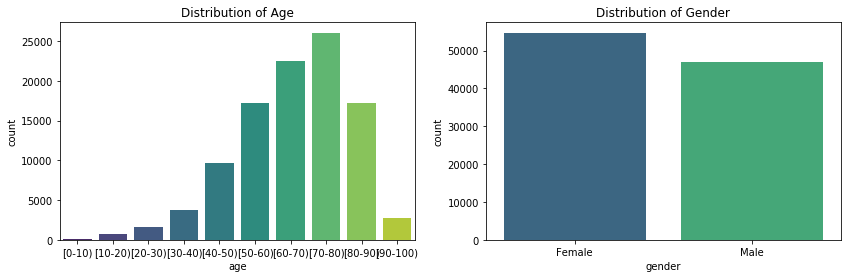

In [48]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.countplot(x='age', data=data, palette='viridis')
plt.title("Distribution of Age")

plt.subplot(1,2,2)
sns.countplot(data['gender'], palette='viridis')
plt.title("Distribution of Gender")
plt.show()

In [27]:
data['gender'].value_counts(normalize=True)

Female    0.537602
Male      0.462398
Name: gender, dtype: float64

The age distribution plot shows that our dataset represents an aging population. The most common age range is 70-80 years old. Our population also has a higher proportion of females than males.

### How long were hospital stays for a given admission?

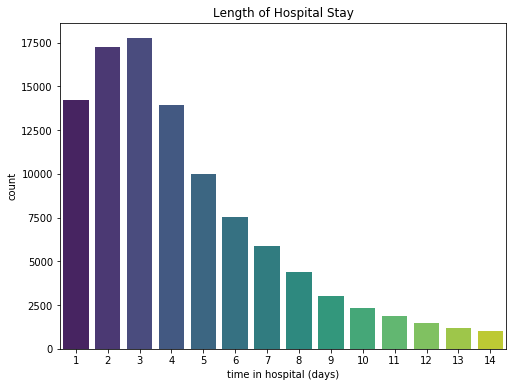

In [28]:
plt.figure(figsize=(8,6))
sns.countplot(data['time_in_hospital'], palette='viridis')
plt.xlabel("time in hospital (days)")
plt.title("Length of Hospital Stay")
plt.show()

In [29]:
print(f"Mean time in hospital: {data['time_in_hospital'].mean():.2f}")

Mean time in hospital: 4.40


Patients stayed on average 4.4 days in hospital. The longest stay was 14 days.

### Number of Diagnoses, Procedures, Medications

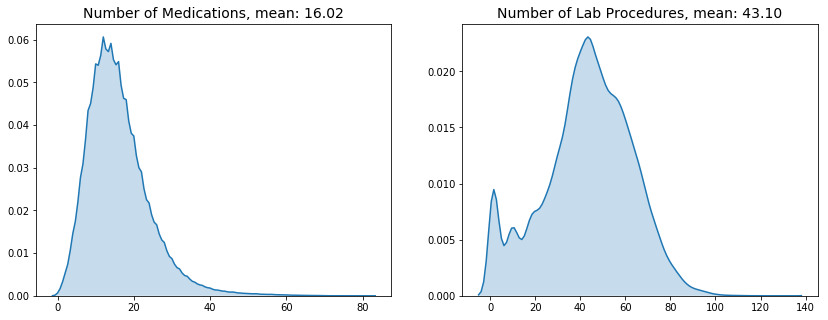

In [56]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.kdeplot(data['num_medications'], shade=True, legend=False)
plt.title(f"Number of Medications, mean: {data['num_medications'].mean():.2f}", size=14)

plt.subplot(1,2,2)
sns.kdeplot(data['num_lab_procedures'], shade=True, legend=False)
plt.title(f"Number of Lab Procedures, mean: {data['num_lab_procedures'].mean():.2f}", size=14)
plt.show()

Patients on average were administered 16 medications during their hospital stay. The average number of lab procedures was 43.

### What was the most common medical specialty?

We also have information on the medical specialty of a patient's attending physician. This can give us a sense of the nature of a patient's illness during their hospital stay. For example, "orthopedics" would suggest that the patient's presenting issue was bone-related, while "nephrology" suggests a kidney problem.

In [62]:
medical_specialties = data['medical_specialty'].value_counts().reset_index()
medical_specialties.columns = ['specialty', 'count']
medical_specialties['prevalence'] = medical_specialties['count']/len(data)
print(f"There are {data['medical_specialty'].nunique()} medical specialties.")
medical_specialties.head(10)

There are 72 medical specialties.


,specialty,count,prevalence
0,InternalMedicine,14635,0.143810
1,Emergency/Trauma,7565,0.074337
2,Family/GeneralPractice,7440,0.073109
3,Cardiology,5352,0.052591
4,Surgery-General,3099,0.030452
5,Nephrology,1613,0.015850
6,Orthopedics,1400,0.013757
7,Orthopedics-Reconstructive,1233,0.012116
8,Radiologist,1140,0.011202
9,Pulmonology,871,0.008559


### What proportion of patients were on diabetes medication during their hospital stay?

In [70]:
data['diabetesMed'].value_counts(normalize=True)

Yes    0.770031
No     0.229969
Name: diabetesMed, dtype: float64

77% of patients were on diabetes medication during their stay.

### Do patients have normal A1C levels?

The A1C blood test is used to diagnose whether a patient has type I or II diabetes, and represents the average levels of blood sugar over the past 3 months. The higher the A1C level, the poorer a patient's blood sugar control which indicates a higher risk of diabetes complications. The table below represents Mayo Clinic's [guideline](https://www.mayoclinic.org/tests-procedures/a1c-test/about/pac-20384643) of how to interpret A1C levels:

|interpretation|A1C level|
|-----------|--------|
|no diabetes|<5.7|
|pre-diabetes|5.7-6.4|
|diabetes|>6.5|
|well-managed diabetes|<7|
|poorly managed diabetes|>8|

Our dataset has a `A1Cresult` which reflects a patient's A1C level during their hospital stay. 

In [71]:
data['A1Cresult'].value_counts(normalize=True)

>8      0.482783
Norm    0.293219
>7      0.223998
Name: A1Cresult, dtype: float64

In [77]:
print(f"Proportion of hospital admissions with missing A1C result: {data['A1Cresult'].isna().sum()/len(data):.2%}")

Proportion of hospital admissions with missing A1C result: 83.28%


Of the hospital admissions where A1C was measured, almost half had a A1C level of greater than 8, which suggests that the patient's diabetes was poorly managed. However, the availability of A1C data is sparse in our dataset, so we may want to consider not including it in the first iteration of our model.

## Step 5: Feature Selection and Engineering

Talk about the importance of feature selection / feature engineering.

## Step 6: Building the Binary Classification ML Model

No Free Lunch Theorem!!!

- Support Vector Machine
- Random Forest Classifier
- K-Neighbours
- Logistic Regression
- AdaBoost Classifier

In [36]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetesMed', 'readmitted', 'admission_type',
       'metformin_bool', 'repaglinide_bool', 'nateglinide_bool',
       'chlorpropamide_bool', 'glimepiride_bool', 'acetohexamide_bool',
       'glipizide_bool', '

In [37]:
from sklearn.ensemble import AdaBoostClassifier

In [38]:
X = data[['metformin_bool', 'repaglinide_bool',
       'nateglinide_bool', 'chlorpropamide_bool', 'glimepiride_bool',
       'acetohexamide_bool', 'glipizide_bool', 'glyburide_bool',
       'tolbutamide_bool', 'pioglitazone_bool', 'rosiglitazone_bool',
       'acarbose_bool', 'miglitol_bool', 'troglitazone_bool',
       'tolazamide_bool', 'examide_bool', 'citoglipton_bool', 'insulin_bool',
       'glyburide-metformin_bool', 'glipizide-metformin_bool',
       'glimepiride-pioglitazone_bool', 'metformin-rosiglitazone_bool',
       'metformin-pioglitazone_bool', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']]

y = data[['readmitted_bool']]

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

In [41]:
model = AdaBoostClassifier(n_estimators=15)
model.fit(X_train, y_train)
model.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.620507529417545